In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import networkx as nx

# P7.2
Add the above solutions for the plots from the previous project.

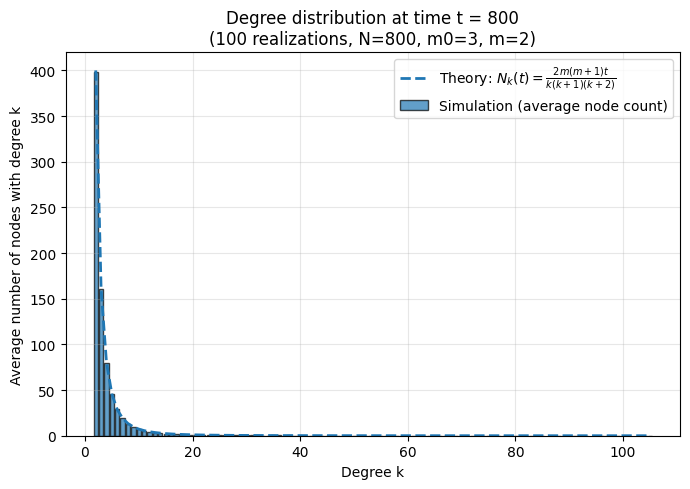

Estimated alpha (linear fit) = 2.5226845706475705
Estimated alpha (MLE)        = 3.0519103004219956
Theoretical BA result: alpha = 3


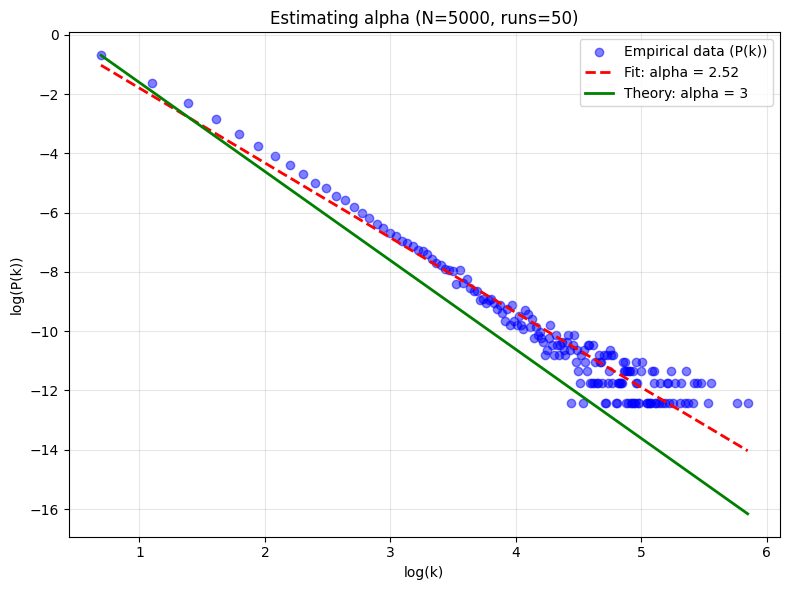

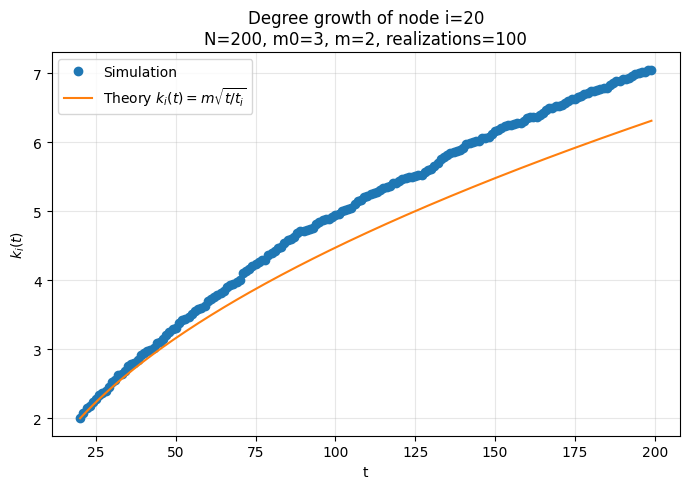

In [3]:
def barabasi_albert_graph(N, m0=3, m=2, seed=None, return_snapshots=False):
    if seed is not None:
        random.seed(seed)

    graph = [set() for _ in range(N)]

    for i in range(m0):
        for j in range(i + 1, m0):
            graph[i].add(j)
            graph[j].add(i)

    degree_list = []
    for i in range(m0):
        degree_list.extend([i] * len(graph[i]))

    snapshots = []

    def to_nx_graph(current_n):
        G = nx.Graph()
        G.add_nodes_from(range(current_n))
        for u in range(current_n):
            for v in graph[u]:
                if v < current_n:
                    G.add_edge(u, v)
        return G

    if return_snapshots:
        snapshots.append(to_nx_graph(m0))

    for new_node in range(m0, N):
        targets = set()
        while len(targets) < m:
            selected = random.choice(degree_list)
            if selected != new_node:
                targets.add(selected)

        for t in targets:
            graph[new_node].add(t)
            graph[t].add(new_node)

        degree_list.extend([new_node] * m)
        for t in targets:
            degree_list.append(t)

        if return_snapshots:
            snapshots.append(to_nx_graph(new_node + 1))

    if return_snapshots:
        return graph, snapshots

    return graph


def get_degrees_from_adjlist(adjlist):
    return [len(neighs) for neighs in adjlist]


def get_empirical_degree_counts(N, t, m0, m, realizations):
    all_degree_counts = Counter()

    for _ in range(realizations):
        graph = barabasi_albert_graph(N, m0=m0, m=m)
        t_graph = graph[:t]
        degrees = get_degrees_from_adjlist(t_graph)
        dist = Counter(degrees)
        all_degree_counts.update(dist)

    for k in all_degree_counts:
        all_degree_counts[k] /= realizations

    return all_degree_counts


def theoretical_Pk(k, m):
    k = np.asarray(k, dtype=float)
    return 2 * m * (m + 1) / (k * (k + 1) * (k + 2))

def theoretical_Nk(k, t, m):
    k = np.asarray(k, dtype=float)
    return 2 * m * (m + 1) * t / (k * (k + 1) * (k + 2))


def plot_degree_histogram_with_theory(N=800, t=800, m0=3, m=2, realizations=100):
    all_degree_counts = get_empirical_degree_counts(N, t, m0, m, realizations)
    degrees = sorted(all_degree_counts.keys())
    counts = np.array([all_degree_counts[k] for k in degrees])

    plt.figure(figsize=(7, 5))
    plt.bar(degrees, counts, edgecolor='black', alpha=0.7,
            label='Simulation (average node count)')

    degrees_arr = np.array(degrees, dtype=float)
    mask = degrees_arr >= m
    k_theory = degrees_arr[mask]

    theory_counts = theoretical_Nk(k_theory, t, m)

    plt.plot(k_theory, theory_counts, linestyle='--', linewidth=2,
             label=r'Theory: $N_k(t)=\frac{2m(m+1)t}{k(k+1)(k+2)}$')


    plt.xlabel("Degree k")
    plt.ylabel("Average number of nodes with degree k")
    plt.title(f"Degree distribution at time t = {t}\n"
              f"({realizations} realizations, N={N}, m0={m0}, m={m})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def get_degrees_from_adjlist_all_realizations(N, m0, m, num_runs):
    all_degrees = []
    for _ in range(num_runs):
        graph = barabasi_albert_graph(N, m0=m0, m=m)
        degrees = get_degrees_from_adjlist(graph)
        all_degrees.extend(degrees)
    return np.array(all_degrees)


def alpha_linear_fit_return(degrees):
    degrees_arr = np.array(degrees)
    k, counts = np.unique(degrees_arr, return_counts=True)
    mask = (k > 0) & (counts > 0)
    k = k[mask]
    pk = counts[mask] / np.sum(counts)

    log_k = np.log(k)
    log_pk = np.log(pk)

    a, b = np.polyfit(log_k, log_pk, 1)
    alpha = -a

    return alpha, k, pk, a, b


def alpha_mle(degrees, k_min):
    data = np.array(degrees)
    data = data[data >= k_min]
    n = len(data)
    return 1 + n / np.sum(np.log(data / k_min))


def plot_loglog_degree_distribution_with_fits(N=5000, m0=3, m=2,
                                              num_runs=50, k_min=8):
    degrees = get_degrees_from_adjlist_all_realizations(N, m0, m, num_runs)
    alpha_lin, k_vals, pk_vals, slope, intercept = alpha_linear_fit_return(degrees)
    alpha_mle_val = alpha_mle(degrees, k_min)

    print("Estimated alpha (linear fit) =", alpha_lin)
    print("Estimated alpha (MLE)        =", alpha_mle_val)
    print("Theoretical BA result: alpha = 3")

    mask = pk_vals > 0
    log_k = np.log(k_vals[mask])
    log_pk = np.log(pk_vals[mask])

    theory_slope = -3
    theory_intercept = log_pk[0] - theory_slope * log_k[0]
    log_pk_theory = theory_slope * log_k + theory_intercept

    plt.figure(figsize=(8, 6))
    plt.scatter(log_k, log_pk, color='blue', alpha=0.5,
                label='Empirical data (P(k))')
    plt.plot(log_k, slope * log_k + intercept, color='red',
             linestyle='--', linewidth=2,
             label=f'Fit: alpha = {alpha_lin:.2f}')
    plt.plot(log_k, log_pk_theory, color='green', linewidth=2,
             label='Theory: alpha = 3')

    plt.title(f"Estimating alpha (N={N}, runs={num_runs})")
    plt.xlabel("log(k)")
    plt.ylabel("log(P(k))")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def simulate_ki_vs_t_with_snapshots(N=200, m0=3, m=2,
                                    node_i=10, realizations=50, seed=None):
    if seed is not None:
        random.seed(seed)

    num_points = N - node_i
    sum_degrees = np.zeros(num_points, dtype=float)

    for _ in range(realizations):
        G_final, snapshots = barabasi_albert_graph(
            N,
            m0=m0,
            m=m,
            seed=None,
            return_snapshots=True
        )

        for G in snapshots:
            current_n = G.number_of_nodes()
            t_curr = current_n - 1
            if t_curr >= node_i:
                idx = t_curr - node_i
                if idx < num_points and node_i < current_n:
                    sum_degrees[idx] += G.degree(node_i)

    avg_degrees = sum_degrees / realizations
    t_values = np.arange(node_i, N)
    t_i = node_i
    k_theory = m * np.sqrt(t_values / t_i)

    return t_values, avg_degrees, k_theory


def plot_ki_vs_t_with_theory(N=200, m0=3, m=2,
                             node_i=20, realizations=100, seed=42):
    t_vals, k_avg, k_th = simulate_ki_vs_t_with_snapshots(
        N=N,
        m0=m0,
        m=m,
        node_i=node_i,
        realizations=realizations,
        seed=seed
    )

    plt.figure(figsize=(7, 5))
    plt.plot(t_vals, k_avg, "o", label="Simulation")
    plt.plot(t_vals, k_th, "-", label=r"Theory $k_i(t)=m\sqrt{t/t_i}$")
    plt.xlabel("t")
    plt.ylabel(r"$k_i(t)$")
    plt.title(
        f"Degree growth of node i={node_i}\n"
        f"N={N}, m0={m0}, m={m}, realizations={realizations}"
    )
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_degree_histogram_with_theory(
        N=800,
        t=800,
        m0=3,
        m=2,
        realizations=100
    )

    plot_loglog_degree_distribution_with_fits(
        N=5000,
        m0=3,
        m=2,
        num_runs=50,
        k_min=8
    )

    plot_ki_vs_t_with_theory(
        N=200,
        m0=3,
        m=2,
        node_i=20,
        realizations=100,
        seed=42
    )


# P7.3
Test which solution fits better to the simulation’s data. [0.5P]


=== P7.3: Fit quality comparison ===
MSE (master-equation solution) : 5.747e-09
MSE (mean-field k^-3 solution) : 1.239e-03
Result: Master-equation solution fits the simulation data better.


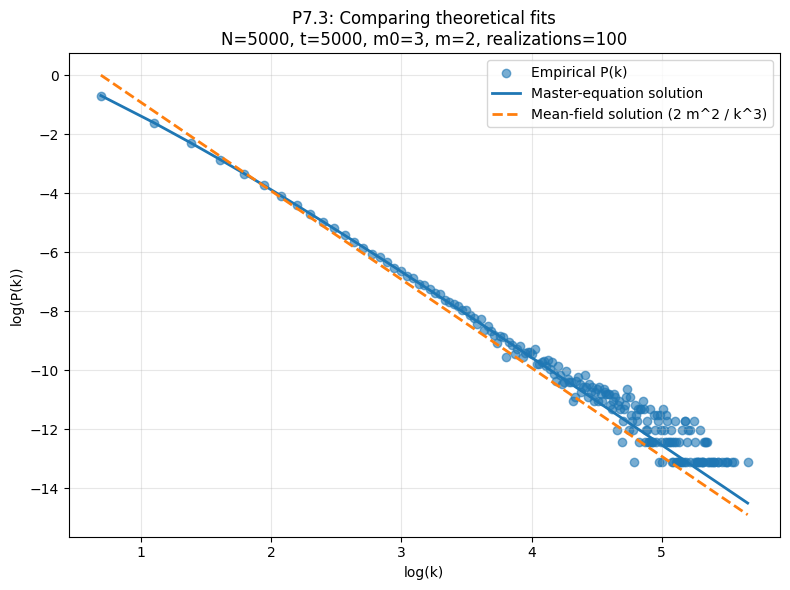

In [9]:
def mean_field_Pk(k, m):
    k = np.asarray(k, dtype=float)
    return 2 * (m ** 2) / (k ** 3)


def test_which_solution_fits_better(N=5000, t=None, m0=3, m=2,
                                    realizations=100, k_min_fit=None, make_plot=True):
    if t is None:
        t = N

    all_degree_counts = get_empirical_degree_counts(N, t, m0, m, realizations)
    degrees = np.array(sorted(all_degree_counts.keys()))
    counts = np.array([all_degree_counts[k] for k in degrees])

    pk_empirical = counts / t

    mask = degrees >= m
    if k_min_fit is not None:
        mask = mask & (degrees >= k_min_fit)

    k_fit = degrees[mask].astype(float)
    pk_fit = pk_empirical[mask]

    pk_me = theoretical_Pk(k_fit, m)
    pk_mf = mean_field_Pk(k_fit, m)

    mse_me = np.mean((pk_fit - pk_me) ** 2)
    mse_mf = np.mean((pk_fit - pk_mf) ** 2)

    print("=== P7.3: Fit quality comparison ===")
    print(f"MSE (master-equation solution) : {mse_me:.3e}")
    print(f"MSE (mean-field k^-3 solution) : {mse_mf:.3e}")

    if mse_me < mse_mf:
        print("Result: Master-equation solution fits the simulation data better.")
    else:
        print("Result: Mean-field solution fits the simulation data better.")

    if make_plot:
        plt.figure(figsize=(8, 6))

        mask_nonzero = (pk_empirical > 0)
        k_plot = degrees[mask_nonzero]
        pk_plot = pk_empirical[mask_nonzero]
        plt.scatter(np.log(k_plot), np.log(pk_plot), label="Empirical P(k)", alpha=0.6)

        pk_me_full = theoretical_Pk(k_plot, m)
        plt.plot(np.log(k_plot), np.log(pk_me_full),
                 label="Master-equation solution", linewidth=2)

        pk_mf_full = mean_field_Pk(k_plot, m)
        plt.plot(np.log(k_plot), np.log(pk_mf_full),
                 label="Mean-field solution (2 m^2 / k^3)",
                 linestyle="--", linewidth=2)

        plt.xlabel("log(k)")
        plt.ylabel("log(P(k))")
        plt.title(f"P7.3: Comparing theoretical fits\nN={N}, t={t}, m0={m0}, m={m}, realizations={realizations}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


test_which_solution_fits_better(
    N=5000,
    t=5000,
    m0=3,
    m=2,
    realizations=100,
    k_min_fit=None,
    make_plot=True
)


# P7.7
Check with simulation the above result. Plot the size of the
largest cluster as a function of ⟨k⟩ = pN. [1P]


<k> = 0.00, p = 0.0000e+00, avg largest cluster fraction = 0.001
<k> = 0.12, p = 6.2500e-05, avg largest cluster fraction = 0.002
<k> = 0.25, p = 1.2500e-04, avg largest cluster fraction = 0.003
<k> = 0.38, p = 1.8750e-04, avg largest cluster fraction = 0.005
<k> = 0.50, p = 2.5000e-04, avg largest cluster fraction = 0.007
<k> = 0.62, p = 3.1250e-04, avg largest cluster fraction = 0.010
<k> = 0.75, p = 3.7500e-04, avg largest cluster fraction = 0.017
<k> = 0.88, p = 4.3750e-04, avg largest cluster fraction = 0.033
<k> = 1.00, p = 5.0000e-04, avg largest cluster fraction = 0.067
<k> = 1.12, p = 5.6250e-04, avg largest cluster fraction = 0.186
<k> = 1.25, p = 6.2500e-04, avg largest cluster fraction = 0.356
<k> = 1.38, p = 6.8750e-04, avg largest cluster fraction = 0.484
<k> = 1.50, p = 7.5000e-04, avg largest cluster fraction = 0.579
<k> = 1.62, p = 8.1250e-04, avg largest cluster fraction = 0.650
<k> = 1.75, p = 8.7500e-04, avg largest cluster fraction = 0.708
<k> = 1.88, p = 9.3750e-0

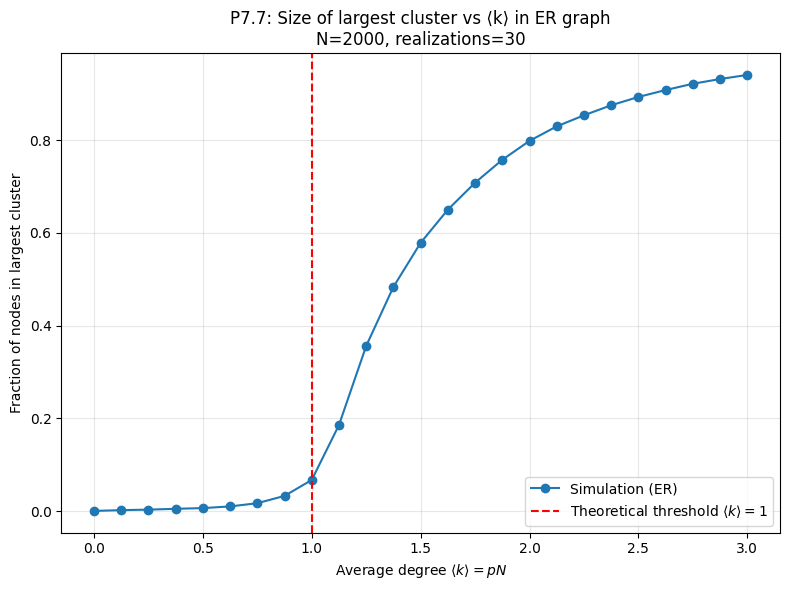

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

def er_largest_cluster_fraction(N, p, realizations=20, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    largest_fractions = []

    for _ in range(realizations):
        G = nx.gnp_random_graph(N, p)
        if G.number_of_nodes() == 0:
            largest_fractions.append(0.0)
            continue

        components = nx.connected_components(G)
        largest_cc = max(components, key=len)
        largest_size = len(largest_cc)

        largest_fractions.append(largest_size / N)

    return np.mean(largest_fractions)


def simulate_er_percolation_vs_kavg(N=2000,
                                    k_min=0.0,
                                    k_max=3.0,
                                    num_k_points=20,
                                    realizations=20,
                                    seed=None):
    k_values = np.linspace(k_min, k_max, num_k_points)
    giant_fractions = []

    for z in k_values:
        p = z / N
        frac = er_largest_cluster_fraction(N, p, realizations=realizations, seed=seed)
        giant_fractions.append(frac)
        print(f"<k> = {z:.2f}, p = {p:.4e}, avg largest cluster fraction = {frac:.3f}")

    return k_values, np.array(giant_fractions)


def plot_er_percolation(N=2000,
                        k_min=0.0,
                        k_max=3.0,
                        num_k_points=20,
                        realizations=20,
                        seed=42):
    k_values, giant_fractions = simulate_er_percolation_vs_kavg(
        N=N,
        k_min=k_min,
        k_max=k_max,
        num_k_points=num_k_points,
        realizations=realizations,
        seed=seed
    )

    plt.figure(figsize=(8, 6))
    plt.plot(k_values, giant_fractions, "o-", label="Simulation (ER)")

    plt.axvline(x=1.0, color="red", linestyle="--",
                label=r"Theoretical threshold $\langle k \rangle = 1$")

    plt.xlabel(r"Average degree $\langle k \rangle = pN$")
    plt.ylabel("Fraction of nodes in largest cluster")
    plt.title(
        f"P7.7: Size of largest cluster vs ⟨k⟩ in ER graph\n"
        f"N={N}, realizations={realizations}"
    )
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_er_percolation(
    N=2000,
    k_min=0.0,
    k_max=3.0,
    num_k_points=25,
    realizations=30,
    seed=42
)

# P7.15
Compare obtained result with simulation from project P7.3.

<k> = 0.00, p = 0.0000e+00, avg largest cluster fraction = 0.001
<k> = 0.17, p = 8.3333e-05, avg largest cluster fraction = 0.003
<k> = 0.33, p = 1.6667e-04, avg largest cluster fraction = 0.004
<k> = 0.50, p = 2.5000e-04, avg largest cluster fraction = 0.007
<k> = 0.67, p = 3.3333e-04, avg largest cluster fraction = 0.012
<k> = 0.83, p = 4.1667e-04, avg largest cluster fraction = 0.027
<k> = 1.00, p = 5.0000e-04, avg largest cluster fraction = 0.067
<k> = 1.17, p = 5.8333e-04, avg largest cluster fraction = 0.235
<k> = 1.33, p = 6.6667e-04, avg largest cluster fraction = 0.448
<k> = 1.50, p = 7.5000e-04, avg largest cluster fraction = 0.579
<k> = 1.67, p = 8.3333e-04, avg largest cluster fraction = 0.671
<k> = 1.83, p = 9.1667e-04, avg largest cluster fraction = 0.743
<k> = 2.00, p = 1.0000e-03, avg largest cluster fraction = 0.799
<k> = 2.17, p = 1.0833e-03, avg largest cluster fraction = 0.839
<k> = 2.33, p = 1.1667e-03, avg largest cluster fraction = 0.869
<k> = 2.50, p = 1.2500e-0

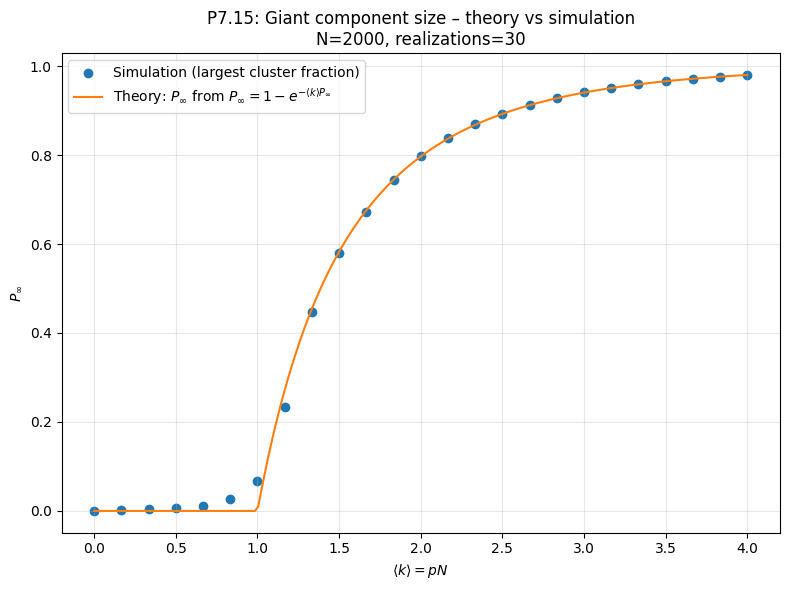

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def solve_Pinf(z, tol=1e-10, max_iter=1000):
    if z <= 1:
        return 0.0

    P = 0.5
    for _ in range(max_iter):
        P_new = 1.0 - np.exp(-z * P)
        if abs(P_new - P) < tol:
            return P_new
        P = P_new
    return P


def compute_theoretical_Pinf(z_values):
    return np.array([solve_Pinf(z) for z in z_values])


def plot_Pinf_theory_vs_simulation(N=2000,
                                   k_min=0.0, k_max=4.0,
                                   num_k_points=25,
                                   realizations=30,
                                   seed=42):

    k_values_sim, giant_fractions = simulate_er_percolation_vs_kavg(
        N=N,
        k_min=k_min,
        k_max=k_max,
        num_k_points=num_k_points,
        realizations=realizations,
        seed=seed
    )

    z_values = np.linspace(k_min, k_max, 200)
    Pinf_theory = compute_theoretical_Pinf(z_values)

    plt.figure(figsize=(8, 6))
    plt.scatter(k_values_sim, giant_fractions,
                label="Simulation (largest cluster fraction)",
                color="tab:blue")

    plt.plot(z_values, Pinf_theory,
             label=r"Theory: $P_\infty$ from $P_\infty = 1 - e^{-\langle k\rangle P_\infty}$",
             color="tab:orange")

    plt.xlabel(r"$\langle k \rangle = pN$")
    plt.ylabel(r"$P_\infty$")
    plt.title(
        f"P7.15: Giant component size – theory vs simulation\n"
        f"N={N}, realizations={realizations}"
    )
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_Pinf_theory_vs_simulation()


# P7.18 Investigate with simulations [2.5P]
• robustness of ER graph and scale-free networks to random failures,
• robustness of ER graph and scale-free networks to intentional
attacks

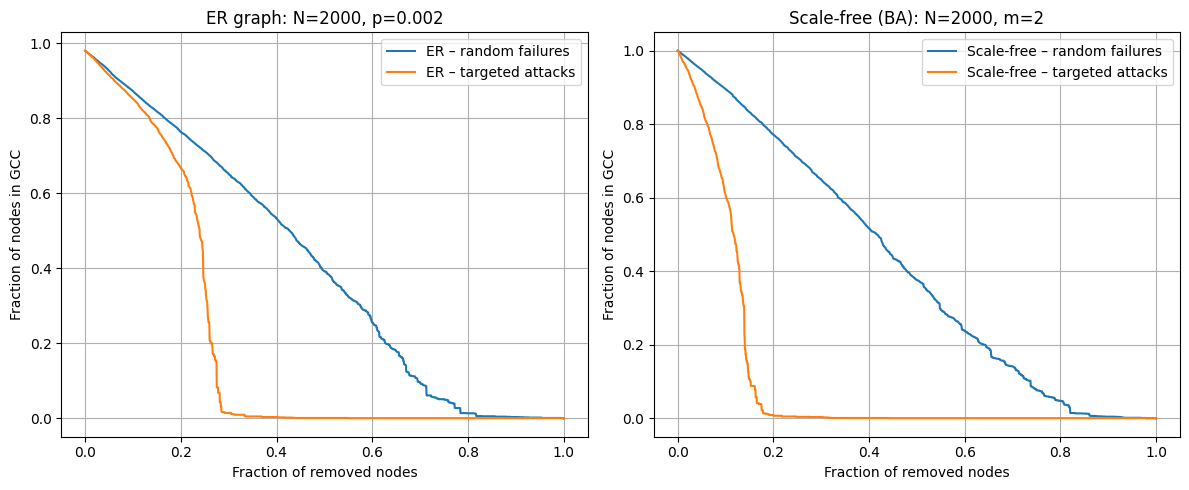

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

def giant_component_fraction_relative_to_N0(G, N0):
    if G.number_of_nodes() == 0:
        return 0.0
    largest = max(nx.connected_components(G), key=len)
    return len(largest) / N0

def simulate_robustness(G, strategy="random"):
    G = G.copy()
    N0 = G.number_of_nodes()

    fractions_removed = [0.0]
    gcc_fractions = [giant_component_fraction_relative_to_N0(G, N0)]

    for t in range(1, N0 + 1):
        if G.number_of_nodes() == 0:
            fractions_removed.append(t / N0)
            gcc_fractions.append(0.0)
            continue

        if strategy == "random":
            node = random.choice(list(G.nodes()))
        elif strategy == "targeted":
            node = max(G.degree, key=lambda x: x[1])[0]
        else:
            raise ValueError("strategy must be 'random' or 'targeted'")

        G.remove_node(node)

        fractions_removed.append(t / N0)
        gcc_fractions.append(giant_component_fraction_relative_to_N0(G, N0))

    return np.array(fractions_removed), np.array(gcc_fractions)

def compare_er_vs_sf(N=2000, p=0.002, m=2, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    G_er = nx.erdos_renyi_graph(N, p, seed=seed)
    G_sf = nx.barabasi_albert_graph(N, m, seed=seed)

    x_er_rand, y_er_rand = simulate_robustness(G_er, strategy="random")
    x_er_targ, y_er_targ = simulate_robustness(G_er, strategy="targeted")

    x_sf_rand, y_sf_rand = simulate_robustness(G_sf, strategy="random")
    x_sf_targ, y_sf_targ = simulate_robustness(G_sf, strategy="targeted")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_er_rand, y_er_rand, label="ER – random failures")
    plt.plot(x_er_targ, y_er_targ, label="ER – targeted attacks")
    plt.xlabel("Fraction of removed nodes")
    plt.ylabel("Fraction of nodes in GCC")
    plt.title(f"ER graph: N={N}, p={p}")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x_sf_rand, y_sf_rand, label="Scale-free – random failures")
    plt.plot(x_sf_targ, y_sf_targ, label="Scale-free – targeted attacks")
    plt.xlabel("Fraction of removed nodes")
    plt.ylabel("Fraction of nodes in GCC")
    plt.title(f"Scale-free (BA): N={N}, m={m}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "ER_random": (x_er_rand, y_er_rand),
        "ER_targeted": (x_er_targ, y_er_targ),
        "SF_random": (x_sf_rand, y_sf_rand),
        "SF_targeted": (x_sf_targ, y_sf_targ),
    }

results = compare_er_vs_sf(N=2000, p=0.002, m=2, seed=0)
